In [1]:
import torch, torchdata, torchtext
import time

from torch import nn

/home/koala/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.1.2+cu121', '0.7.1', '0.16.2+cpu')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [4]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. ETL

In [5]:
from torchtext.datasets import AG_NEWS

In [6]:
AG_NEWS

<function torchtext.datasets.ag_news.AG_NEWS(root: str = '.data', split: Union[Tuple[str], str] = ('train', 'test'))>

In [7]:
train, test = AG_NEWS()
train, test

(ShardingFilterIterDataPipe, ShardingFilterIterDataPipe)

In [8]:
len(list(iter(train)))

120000

In [9]:
len(list(iter(test)))

7600

### 2. EDA

In [10]:
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [11]:
set([y for y,x in list(iter(train))])

/home/koala/.local/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


{1, 2, 3, 4}

In [12]:
train_size = len(list(iter(train)))
train_size ## dataset too big need to reduce

120000

In [13]:
_, train, valid = train.random_split(total_length=train_size,
                                     weights = {'too much': 0.7,"train": 0.2, "val": 0.1},
                                     seed = SEED )
                                    # random_split returns tuple

In [14]:
len(list(iter(train)))

24000

In [15]:
len(list(iter(valid)))

12000

In [16]:
len(list(iter(test)))

7600

### 3. Preprocessing

#### Tokenizing

In [17]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_md')

In [18]:
tokens = tokenizer('We are currently learning LSTM in youtube!')
tokens

['We', 'are', 'currently', 'learning', 'LSTM', 'in', 'youtube', '!']

#### Text to integers

In [19]:
from torchtext.vocab import build_vocab_from_iterator 

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [20]:
train_iter = yield_tokens(train)
print(next(train_iter))

['Safety', 'Net', '(', 'Forbes.com', ')', 'Forbes.com', '-', 'After', 'earning', 'a', 'PH.D.', 'in', 'Sociology', ',', 'Danny', 'Bazil', 'Riley', 'started', 'to', 'work', 'as', 'the', 'general', 'manager', 'at', 'a', 'commercial', 'real', 'estate', 'firm', 'at', 'an', 'annual', 'base', 'salary', 'of', ' ', '#', '36;70,000', '.', 'Soon', 'after', ',', 'a', 'financial', 'planner', 'stopped', 'by', 'his', 'desk', 'to', 'drop', 'off', 'brochures', 'about', 'insurance', 'benefits', 'available', 'through', 'his', 'employer', '.', 'But', ',', 'at', '32', ',', '"', 'buying', 'insurance', 'was', 'the', 'furthest', 'thing', 'from', 'my', 'mind', ',', '"', 'says', 'Riley', '.']


In [21]:
#Generator Function: When yield is used in a function, it turns the function into a generator function.

In [22]:
#In practice, yield_tokens would be used to efficiently tokenize a large dataset iteratively, without needing to load the entire tokenized dataset into memory. 
#This can be particularly useful in natural language processing (NLP) tasks where datasets can be very large, and memory efficiency is important. 
#You could use this function in a data preprocessing pipeline, feeding the tokenized output directly into a model for training or inference in a memory-efficient manner.

In [23]:
vocab = build_vocab_from_iterator(yield_tokens(train), specials = ['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])

/home/koala/.local/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [24]:
vocab['ddd']

0

In [25]:
# integers to text

mapping = vocab.get_itos()

mapping[0]

'<unk>'

In [26]:
len(vocab)

52686

### 4. FastText Embeddings

In [27]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [28]:
fast_embeddings = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [29]:
len(fast_embeddings[1])

300

In [30]:
fast_embeddings.shape # vocab, emb_dim

torch.Size([52686, 300])

In [31]:
type(fast_embeddings)

torch.Tensor

### 5. Preparing the dataloader

In [32]:
text_pipeline = lambda x: vocab(tokenizer(x)) # tokenized then numericalized

In [33]:
text_pipeline('I am currently learning LSTM')

[278, 3198, 3626, 7685, 0]

In [34]:
label_pipeline = lambda x: int(x)-1

In [35]:
# collate fn 

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #[278, 3198, 3626, 11974, 0]
                                            #[4, 2, 1, <pad>, <pad>]

pad_dix = vocab['<pad>']

In [36]:
pad_idx = vocab['<pad>']


def collate_batch(batch):

    label_list, text_list, lenght_list = [], [], []

    for (label, text) in batch:

        label_list.append(label_pipeline(label))

        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)

        lenght_list.append(processed_text.size(0)) # needed for padded sequence

    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True), torch.tensor(lenght_list, dtype=torch.int64)
    # batch will be always first ==> batch = True

In [37]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader   = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [38]:
for label, text, length in train_loader:
    print(len(label))
    print(len(text))
    print(len(length))
    break

64
64
64


In [39]:
print(label.shape)  #batch_size, 
print(text.shape)   #batch_size, seq_len
print(length.shape) #batch_size,

torch.Size([64])
torch.Size([64, 111])
torch.Size([64])


### 6. Design the model

In [76]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers,
                        bidirectional, dropout, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_dix)
        self.lstm      = nn.LSTM(
                            emb_dim,
                            hid_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout=dropout,
                            batch_first=True
                        )   
        self.fc         = nn.Linear(hid_dim * 2, output_dim)


# output_dim = prediction head
    def forward(self, text, text_length): # label would be include in training
        # text = [batch_size, seq_len]
        embedded = self.embedding(text)
        print('embedded: ', embedded.shape)
        # text = [batch_size, seq_len, emb_dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'),
                                                            enforce_sorted = False, batch_first = True)
        
        # print('packed_embedded: ', packed_embedded)
        
        packed_output, (hn,cn) = self.lstm(packed_embedded)

        # print('packed_output: ', packed_output.shape)
        print('hn: ', hn.shape)
        print('cn: ', cn.shape)


        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)


        print('output: ', output.shape)
        print('output_length: ', output_lengths.shape)
        
        #output = [batch_size, seq len, hidden_dim * num directions]
        #hn     = [num_layers * num_directions, batch_size,  hid_dim]  #3 layers birectional - hn1f, hn1b, hn2f, hn2b, hn3f, hn3b
        #cn     = [num_layers * num_directions, batch_size,  hid_dim]
        
        hn      = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1)
        #hn     = [batch_size, hidden_dim * num_directions]

        print('hn: ', hn.shape)
        
        return self.fc(hn)

### 7. Training

In [77]:
def initialize_weight(m): # randomly initialize weights and may reach convergence much faster

    if isinstance(m, nn.Linear):

        nn.init.xavier_normal_(m.weight) # try to make all the weights within normal distribution
        nn.init.zeros_(m.bias)           

    elif isinstance(m, nn.LSTM):

        for name, param in m.named_parameters():

            if 'bias' in name:
                nn.init.zeros_(param)

            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [78]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300 #fasttext
output_dim = 4 #four types of news
num_layers = 2
bidirectional = True
dropout    = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, num_layers, bidirectional, dropout, output_dim)

model.apply(initialize_weight)

model.embedding.weight.data = fast_embeddings

model.to(device)

LSTM(
  (embedding): Embedding(52686, 300, padding_idx=1)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [79]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(sum(params))    

In [80]:
count_parameters(model)

18527596


In [81]:
import torch.optim as optim

lr        = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [82]:
def accuracy(preds, y):
    predicted  = torch.max(preds.data, 1)[1] 
    batch_corr = (predicted == y).sum() # batch_correctness
    acc        = batch_corr / len(y)
    return acc

In [83]:
def train(model, loader, optimizer, criterion, loader_length):

    epoch_loss  = 0
    epoch_acc   = 0
    model.train()

    for i, (label, text, text_length) in enumerate(loader):

        label = label.to(device)
        text  = text.to(device)

        predictions = model(text, text_length).squeeze(1)
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [84]:
def evaluate(model, loader, criterion, loader_length):

    epoch_loss  = 0
    epoch_acc   = 0
    model.eval()

    with torch.no_grad():

        for i, (label, text, text_length) in enumerate(loader):

            label = label.to(device)
            text  = text.to(device)

            predictions = model(text, text_length).squeeze(1)
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

#### Actual training

In [85]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [86]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [87]:
import time

best_valid_loss = float('inf')
num_epochs      = 10

save_path       = f'models/{model.__class__.__name__}.pt'

train_losses, train_accs, val_losses, val_accs = [],[],[],[]

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = train(model, val_loader,   optimizer, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal.  Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.2f}%')
        

embedded:  torch.Size([64, 111, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 111, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 83, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 83, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 87, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 87, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 80, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 80, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 80, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 80, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 133, 300])


### 8. Plotting

Text(0, 0.5, 'loss')

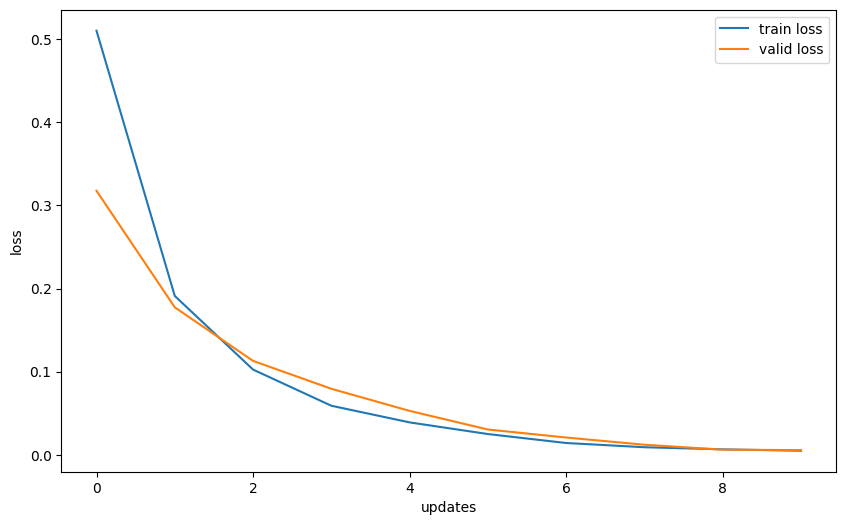

In [88]:
import matplotlib.pyplot as plt

fig  = plt.figure(figsize=(10, 6))
ax   = fig.add_subplot(1, 1, 1)

ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'valid loss')

plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

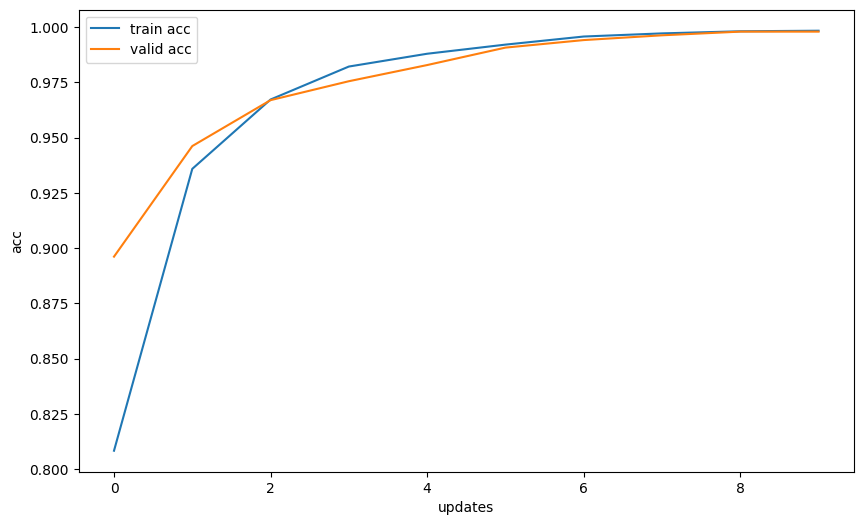

In [89]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_accs, label = 'train acc')
ax.plot(val_accs, label = 'valid acc')

plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [90]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

embedded:  torch.Size([64, 159, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 159, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 133, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 133, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 116, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 116, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 98, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 98, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 72, 300])
hn:  torch.Size([4, 64, 256])
cn:  torch.Size([4, 64, 256])
output:  torch.Size([64, 72, 512])
output_length:  torch.Size([64])
hn:  torch.Size([64, 512])
embedded:  torch.Size([64, 83, 300

### 9. Test on random news

In [91]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  199,    27,   239,  1965, 48161,     6,    14,    21,   396,    27,
         2121,  1378,   239,     6], device='cuda:0')

In [92]:
text_list = [x.item() for x in text]
text_list

[199, 27, 239, 1965, 48161, 6, 14, 21, 396, 27, 2121, 1378, 239, 6]

In [93]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [94]:
text = text.reshape(1, -1)  #because batch_size is 1

In [95]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [96]:
text.shape

torch.Size([1, 14])

In [97]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [ ]:
predict(text, text_length)